<picture>
  <source media="(prefers-color-scheme: dark)" srcset="https://assets.vespa.ai/logos/Vespa-logo-green-RGB.svg">
  <source media="(prefers-color-scheme: light)" srcset="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg">
  <img alt="#Vespa" width="200" src="https://assets.vespa.ai/logos/Vespa-logo-dark-RGB.svg" style="margin-bottom: 25px;">
</picture>

# Evaluating a Vespa Application

We are often asked by users and customers what is the best retrieval and ranking strategy for a given use case. And even though we might sometimes have an intuition, we always recommend to set up experiments and do a proper quantitative evaluation.

This guide will show how you easily can evaluate a Vespa application using pyvespa's `VespaEvaluator` class.

We will define and compare 3 different ranking strategies in this guide:

1. BM25 (The solid baseline)
2. Semantic (using https://huggingface.co/intfloat/e5-small-v2)
3. Fusion (Combining BM25 and Semantic with [reciprocal rank fusion](https://docs.vespa.ai/en/phased-ranking.html#cross-hit-normalization-including-reciprocal-rank-fusion))

<div class="alert alert-info">
    Refer to <a href="https://pyvespa.readthedocs.io/en/latest/troubleshooting.html">troubleshooting</a>
    for any problem when running this guide.
</div>


**Pre-requisite**: Create a tenant at [cloud.vespa.ai](https://cloud.vespa.ai/), save the tenant name.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vespa-engine/pyvespa/blob/master/docs/sphinx/source/getting-started-pyvespa-cloud.ipynb)


## Install

Install [pyvespa](https://pyvespa.readthedocs.io/) >= 0.53.0
and the [Vespa CLI](https://docs.vespa.ai/en/vespa-cli.html).
The Vespa CLI is used for data and control plane key management ([Vespa Cloud Security Guide](https://cloud.vespa.ai/en/security/guide)).


In [1]:
!pip3 install pyvespa vespacli datasets pandas

## Configure application


In [48]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "vespa-team"
# Replace with your application name (does not need to exist yet)
application = "evaluation"
schema_name = "doc"

## Create an application package

The [application package](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.package.ApplicationPackage)
has all the Vespa configuration files -
create one from scratch:


In [3]:
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    HNSW,
    RankProfile,
    Component,
    Parameter,
    FieldSet,
    GlobalPhaseRanking,
    Function,
)

package = ApplicationPackage(
    name=application,
    schema=[
        Schema(
            name=schema_name,
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(
                        name="text",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                        bolding=True,
                    ),
                    Field(
                        name="embedding",
                        type="tensor<float>(x[384])",
                        indexing=[
                            "input text",
                            "embed",  # uses default model
                            "index",
                            "attribute",
                        ],
                        ann=HNSW(distance_metric="angular"),
                        is_document_field=False,
                    ),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
            rank_profiles=[
                RankProfile(
                    name="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[Function(name="bm25sum", expression="bm25(text)")],
                    first_phase="bm25sum",
                ),
                RankProfile(
                    name="semantic",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    first_phase="closeness(field, embedding)",
                ),
                RankProfile(
                    name="fusion",
                    inherits="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    first_phase="closeness(field, embedding)",
                    global_phase=GlobalPhaseRanking(
                        expression="reciprocal_rank_fusion(bm25sum, closeness(field, embedding))",
                        rerank_count=1000,
                    ),
                ),
            ],
        )
    ],
    components=[
        Component(
            id="e5",
            type="hugging-face-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "url": "https://huggingface.co/intfloat/e5-small-v2/resolve/main/model.onnx"
                    },
                ),
                Parameter(
                    "tokenizer-model",
                    {
                        "url": "https://huggingface.co/intfloat/e5-small-v2/resolve/main/tokenizer.json"
                    },
                ),
            ],
        )
    ],
)

Note that the name cannot have `-` or `_`.


## Deploy to Vespa Cloud

The app is now defined and ready to deploy to Vespa Cloud.

Deploy `package` to Vespa Cloud, by creating an instance of
[VespaCloud](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.deployment.VespaCloud):


In [4]:
from vespa.deployment import VespaCloud
import os

# Key is only used for CI/CD. Can be removed if logging in interactively

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    key_content=os.getenv(
        "VESPA_TEAM_API_KEY", None
    ),  # Key is only used for CI/CD. Can be removed if logging in interactively
    application_package=package,
)

Setting application...
Running: vespa config set application scoober.evaluation
Setting target cloud...
Running: vespa config set target cloud

Api-key found for control plane access. Using api-key.


For more details on different authentication options and methods, see [authenticating-to-vespa-cloud](https://pyvespa.readthedocs.io/en/latest/authenticating-to-vespa-cloud.html).

The following will upload the application package to Vespa Cloud Dev Zone (`aws-us-east-1c`), read more about [Vespa Zones](https://cloud.vespa.ai/en/reference/zones.html).
The Vespa Cloud Dev Zone is considered as a sandbox environment where resources are down-scaled and idle deployments are expired automatically.
For information about production deployments, see the following [method](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.deployment.VespaCloud.deploy_to_prod).

> Note: Deployments to dev and perf expire after 7 days of inactivity, i.e., 7 days after running deploy. This applies to all plans, not only the Free Trial. Use the Vespa Console to extend the expiry period, or redeploy the application to add 7 more days.


Now deploy the app to Vespa Cloud dev zone.

The first deployment typically takes 2 minutes until the endpoint is up. (Applications that for example refer to large onnx-models may take a bit longer.)


In [ ]:
app = vespa_cloud.deploy(application_package=package)

Waiting for configuration server, 0/60 seconds...
Waiting for configuration server, 5/60 seconds...
Waiting for application to come up, 0/300 seconds.
Waiting for application to come up, 5/300 seconds.
Waiting for application to come up, 10/300 seconds.
Application is up!
Finished deployment.


If the deployment failed, it is possible you forgot to add the key in the Vespa Cloud Console in the `vespa auth api-key` step above.

If you can authenticate, you should see lines like the following

```
 Deployment started in run 1 of dev-aws-us-east-1c for mytenant.hybridsearch.
```

The deployment takes a few minutes the first time while Vespa Cloud sets up the resources for your Vespa application

`app` now holds a reference to a [Vespa](https://pyvespa.readthedocs.io/en/latest/reference-api.html#vespa.application.Vespa) instance. We can access the
mTLS protected endpoint name using the control-plane (vespa_cloud) instance. This endpoint we can query and feed to (data plane access) using the
mTLS certificate generated in previous steps.


In [6]:
# endpoint = vespa_cloud.get_mtls_endpoint()
# endpoint

## Getting your evaluation data

For evaluating information retrieval methods, in addition to the document corpus, we also need a set of queries and a mapping from queries to relevant documents.

For this guide, we will use the [NanoMSMARCO](https://huggingface.co/datasets/zeta-alpha-ai/NanoMSMARCO) dataset, made available on huggingface by [Zeta Alpha](https://zeta-alpha.com/).

This dataset is a subset of their 🍺[NanoBEIR](https://huggingface.co/collections/zeta-alpha-ai/nanobeir-66e1a0af21dfd93e620cd9f6)-collection, with 50 queries and up to 10K documents each. 

This is a great dataset for testing and evaluating information retrieval methods quickly, as it is small and easy to work with. 

Note that for almost any real-world use case, we would recommend you to create your own evaluation dataset. See [Vespa blog post](https://blog.vespa.ai/improving-retrieval-with-llm-as-a-judge/) on how you can get help from an LLM for this. 

In [7]:
from datasets import load_dataset

dataset_id = "zeta-alpha-ai/NanoMSMARCO"

dataset = load_dataset(dataset_id, "corpus", split="train", streaming=True)
vespa_feed = dataset.map(
    lambda x: {
        "id": x["_id"],
        "fields": {"text": x["text"], "id": x["_id"]},
    }
)

In [8]:
query_ds = load_dataset(dataset_id, "queries", split="train")
qrels = load_dataset(dataset_id, "qrels", split="train")

In [63]:
ids_to_query = dict(zip(query_ds["_id"], query_ds["text"]))

Let us print the first 5 queries:

In [10]:
for idx, (qid, q) in enumerate(ids_to_query.items()):
    print(f"qid: {qid}, query: {q}")
    if idx == 5:
        break

qid: 994479, query: which health care system provides all citizens or residents with equal access to health care services
qid: 1009388, query: what's right in health care
qid: 1088332, query: weather in oran
qid: 265729, query: how long keep financial records
qid: 1099433, query: how do hoa fees work
qid: 200600, query: heels or heal


In [64]:
relevant_docs = dict(zip(qrels["query-id"], qrels["corpus-id"]))

Let us print the first 5 query ids and their relevant documents:

In [12]:
for idx, (qid, doc_id) in enumerate(relevant_docs.items()):
    print(f"qid: {qid}, doc_id: {doc_id}")
    if idx == 5:
        break

qid: 994479, doc_id: 7275120
qid: 1009388, doc_id: 7248824
qid: 1088332, doc_id: 7094398
qid: 265729, doc_id: 7369987
qid: 1099433, doc_id: 7255675
qid: 200600, doc_id: 7929603


We can see that this dataset only has one relevant document per query.
The `VespaEvaluator` class handles this just fine, but you could also provide a set of relevant documents per query if there are multiple relevant docs.

```python
qrels = {
    "q1": {"doc1", "doc2"},
    "q2": {"doc3", "doc4"},
    # etc. 
}
```

Now we can feed to Vespa using `feed_iterable` which accepts any `Iterable` and an optional callback function where we can
check the outcome of each operation. The application is configured to use [embedding](https://docs.vespa.ai/en/embedding.html)
functionality, that produce a vector embedding using a concatenation of the title and the body input fields. This step may be resource intensive, depending on the model size.

Read more about embedding inference in Vespa in the [Accelerating Transformer-based Embedding Retrieval with Vespa](https://blog.vespa.ai/accelerating-transformer-based-embedding-retrieval-with-vespa/)
blog post.

Default node resources in Vespa Cloud have 2 v-cpu for the Dev Zone.


In [13]:
from vespa.io import VespaResponse


def callback(response: VespaResponse, id: str):
    if not response.is_successful():
        print(f"Error when feeding document {id}: {response.get_json()}")


app.feed_iterable(vespa_feed, schema="doc", namespace="tutorial", callback=callback)

In [ ]:
from vespa.evaluation import VespaEvaluator
import vespa.querybuilder as qb


def semantic_query_fn(query_text: str, top_k: int) -> dict:
    """
    Convert a plain text user query to a Vespa query body dict.
    The example below uses a YQL statement and requests a fixed number of hits.
    Adapt this for your ranking profile, filters, etc.
    """
    return {
        "yql": str(
            qb.select("*")
            .from_(schema_name)
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "semantic",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
        "presentation.timing": True,
    }


def bm25_query_fn(query_text: str, top_k: int) -> dict:
    """
    Convert a plain text user query to a Vespa query body dict.
    The example below uses a YQL statement and requests a fixed number of hits.
    Adapt this for your ranking profile, filters, etc.
    """
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "bm25",
        "hits": top_k,
        "presentation.timing": True,
    }


def fusion_query_fn(query_text: str, top_k: int) -> dict:
    """
    Convert a plain text user query to a Vespa query body dict.
    The example below uses a YQL statement and requests a fixed number of hits.
    Adapt this for your ranking profile, filters, etc.
    """
    return {
        "yql": str(
            qb.select("*")
            .from_(schema_name)
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        # "select * from sources * where userQuery() OR ({targetHits:1000}nearestNeighbor(embedding,q));",
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed({query_text})",
        "hits": top_k,
        "presentation.timing": True,
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
all_results = {}
for evaluator_name, query_fn in [
    ("semantic", semantic_query_fn),
    ("bm25", bm25_query_fn),
    ("fusion", fusion_query_fn),
]:
    print(f"Evaluating {evaluator_name}...")
    evaluator = VespaEvaluator(
        queries=ids_to_query,
        relevant_docs=relevant_docs,
        vespa_query_fn=query_fn,
        app=app,
        name=evaluator_name,
        write_csv=True,  # optionally write metrics to CSV
    )

    results = evaluator()
    all_results[evaluator_name] = results

Evaluating semantic...
Evaluating bm25...
Evaluating fusion...


In [60]:
all_results

{'semantic': {'accuracy@1': 0.38,
  'accuracy@3': 0.64,
  'accuracy@5': 0.72,
  'accuracy@10': 0.82,
  'precision@1': 0.38,
  'precision@3': 0.21333333333333332,
  'precision@5': 0.14400000000000002,
  'precision@10': 0.08199999999999999,
  'recall@1': 0.38,
  'recall@3': 0.64,
  'recall@5': 0.72,
  'recall@10': 0.82,
  'mrr@10': 0.5308571428571428,
  'ndcg@10': 0.6007397354752749,
  'map@100': 0.5393493336728631,
  'searchtime_avg': 0.00668,
  'searchtime_q50': 0.006,
  'searchtime_q90': 0.007,
  'searchtime_q95': 0.008},
 'bm25': {'accuracy@1': 0.3,
  'accuracy@3': 0.6,
  'accuracy@5': 0.66,
  'accuracy@10': 0.76,
  'precision@1': 0.3,
  'precision@3': 0.2,
  'precision@5': 0.132,
  'precision@10': 0.07600000000000001,
  'recall@1': 0.3,
  'recall@3': 0.6,
  'recall@5': 0.66,
  'recall@10': 0.76,
  'mrr@10': 0.4520793650793651,
  'ndcg@10': 0.526410407397105,
  'map@100': 0.45999902392693265,
  'searchtime_avg': 0.0053,
  'searchtime_q50': 0.005,
  'searchtime_q90': 0.006,
  'searcht

<Axes: >

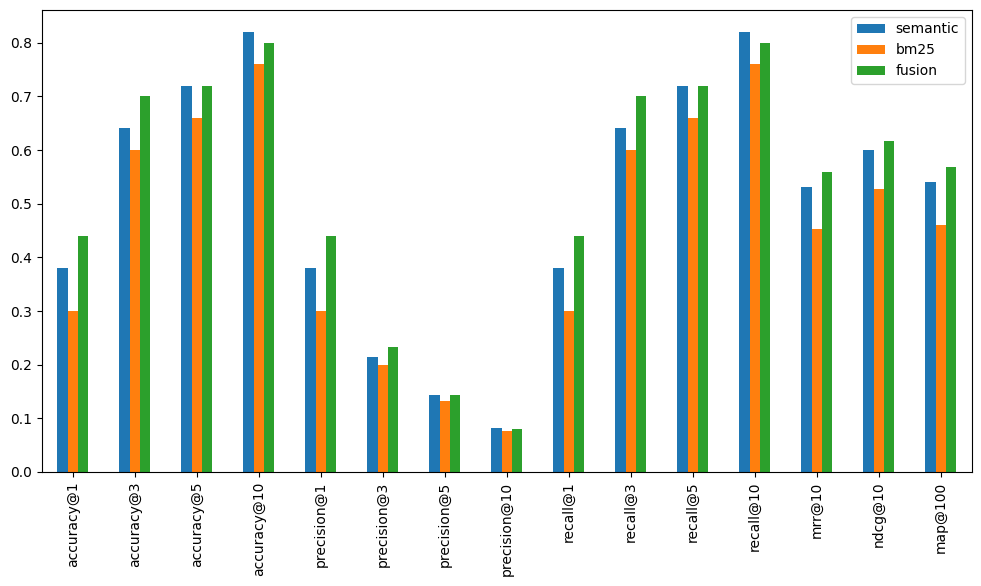

In [61]:
import pandas as pd

results = pd.DataFrame(all_results)
# take out all rows with "searchtime" to a separate dataframe
searchtime = results[results.index.str.contains("searchtime")]
results = results[~results.index.str.contains("searchtime")]
results.plot(kind="bar", figsize=(12, 6))

<Axes: >

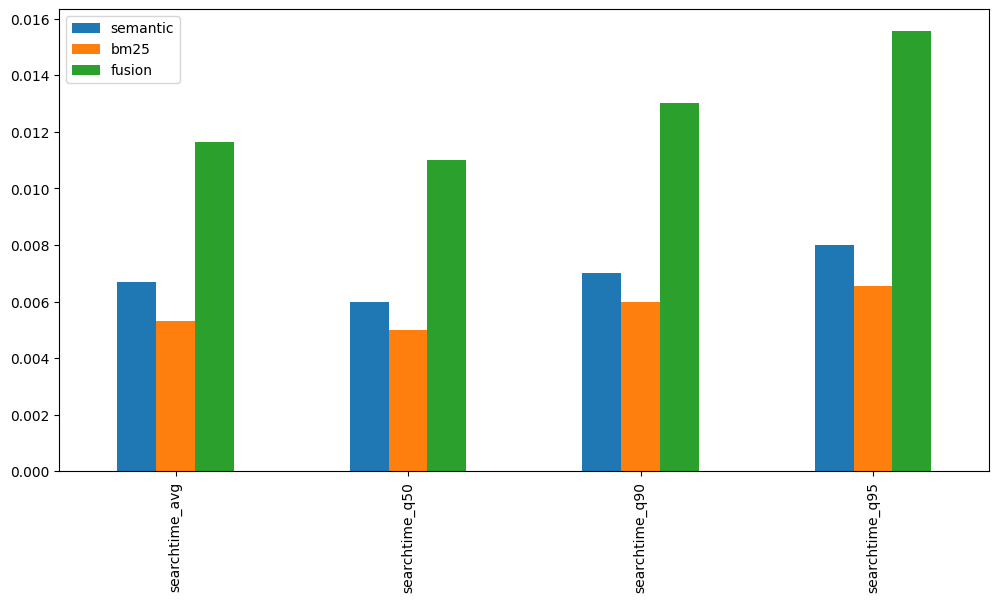

In [62]:
searchtime.plot(kind="bar", figsize=(12, 6))

In [20]:
vespa_cloud.delete()

HTTPError: HTTP 401 reason: Unauthorized error_text: {
  "code" : 401,
  "message" : "Access denied - not authenticated"
} for /application/v4/tenant/scoober/application/evaluation/instance/default/environment/dev/region/aws-us-east-1c